## Human Activity Recognition Using Smartphones

#### Classification Model Comparison

#### Name: Akeem Jokosenumi

#### Student ID: G00366442

#### Introduction

#### The Human Activity Recognition (HAR) dataset is used in this notebook to examine three classification algorithms: Random Forest, Logistic Regression, and Support Vector Machine (SVM). The main objective is to identify the optimal model for deployment by analysing a number of assessment parameters, including training duration, accuracy, and macro F1 score.

#### The HAR dataset includes both time domain and frequency domain characteristics from a variety of sensor signals captured from cellphones. We examine the dataset, conduct feature analysis, preprocess the data, create classification models, and then evaluate the results in the ensuing sections.

In [27]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Set plotting style (using seaborn theme)
sns.set_theme(style="whitegrid")

In [28]:
# Set student ID as random seed so G00366442 becomes 366442
import numpy as np

STUDENT_ID = 366442
np.random.seed(STUDENT_ID)

# Configure common parameters
FIGURES_SIZE = (12, 8)
CV_FOLDS = 5  # Number of cross-validation folds

In [29]:
# Verify imports are working
import pandas as pd
import matplotlib
import seaborn as sns
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Pandas version: 2.2.0
NumPy version: 1.26.4
Matplotlib version: 3.9.0
Seaborn version: 0.13.2


## Dataset Overview and Feature Analysis

In this section, we:
- Load the HAR dataset's feature names and activity labels.
- Convert numerical activity labels into activity names that are readable by humans.
- Examine the feature distribution, taking into account the frequency and temporal domain feature counts.
- Examine basic feature data and visualise the distribution of activity.

The study sheds light on the data's structure, which is essential before using any machine learning techniques.

In [30]:
def load_data():
    """
    Load the UCI HAR dataset.
    - 'dataset.txt' contains the features.
    - 'targets.txt' contains the labels.
    - 'features.txt' contains feature names.
    """
    # Load feature names and strip extra spaces
    features = pd.read_csv('UCI HAR/features.txt', sep='\s+', header=None, dtype=str)
    feature_names = features[1].str.strip().tolist()
    
    # Load feature data and assign feature names (as float)
    X = pd.read_csv('UCI HAR/dataset.txt', sep='\s+', header=None, dtype=float)
    X.columns = feature_names
    
    # Check for duplicate column names and resolve them
    X.columns = [f'{col}_{i}' if X.columns.tolist().count(col) > 1 else col for i, col in enumerate(X.columns)]
    
    # Load target labels as a DataFrame with column name 'activity'
    y = pd.read_csv('UCI HAR/targets.txt', sep='\s+', header=None, names=['activity'])
    
    # Ensure activity column is numeric
    y['activity'] = pd.to_numeric(y['activity'], errors='coerce')
    y = y.dropna(subset=['activity'])
    y['activity'] = y['activity'].astype(int)
    
    # Define activity label mapping
    activity_labels = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'
    }
    
    # Map numeric labels to activity names for visualization
    y['activity_name'] = y['activity'].map(activity_labels)
    
    return X, y, activity_labels


### Handling Class Imbalance with Random Oversampling

#### **Purpose:**
In real-world datasets, the model may favour majority classes due to **imbalanced learning**, where some classes may have much less samples than others. In order to solve this, we create more synthetic samples for under-represented classes using **Random Oversampling**.

#### **How It Works:**
1. `RandomOverSampler` is used to apply **Random Oversampling (ROS)** to the dataset, guaranteeing that each activity class has an equal amount of samples.
2. **Labels for Activities Are Maintained**: The function makes sure that the labels and the names of the corresponding activities are consistently mapped.
3. **Maintains Data Integrity**: To maintain feature names and column consistency, the resampled dataset is converted back into a structured DataFrame.

In [31]:
def balance_classes(X, y):
    """I'll use random oversampling to balance the distribution of the classes."""
    ros = RandomOverSampler(random_state=366442)
    
    # Ensure y is using integer labels
    y_int = y.copy()
    y_int['activity'] = y_int['activity'].astype(int)
    
    X_resampled, y_resampled = ros.fit_resample(X, y_int['activity'])
    
    # Convert back to pandas objects (preserve column names)
    X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    y_resampled = pd.DataFrame({'activity': y_resampled})
    y_resampled['activity'] = y_resampled['activity'].astype(int)
    
    # Map activity names
    activity_labels = {
        1: 'Walking',
        2: 'Walking Upstairs',
        3: 'Walking Downstairs',
        4: 'Sitting',
        5: 'Standing',
        6: 'Laying'
    }
    y_resampled['activity_name'] = y_resampled['activity'].map(activity_labels)
    
    return X_resampled, y_resampled


## Data Cleaning and Transformation
- **Feature Standardization**: Using `StandardScaler` to normalize features to zero mean and unit variance
- **Missing Value Treatment**: Rows with NaN values are removed
- **Outlier Removal**: Data points beyond 3 standard deviations are filtered out


In [32]:
def clean_data(X):
    """
    I will remove rows with NaN values and extreme outliers..
    Return the cleaned data along with a boolean mask that indicates which rows were kept.
    """
    X_clean = X.copy()
    mask = pd.Series(True, index=X.index)
    
    # Remove rows with any NaN values
    mask = mask & ~X_clean.isna().any(axis=1)
    
    # Remove extreme outliers (values beyond 3 standard deviations)
    for col in X_clean.columns:
        mean = X_clean[col].mean()
        std = X_clean[col].std()
        outlier_mask = (X_clean[col] - mean).abs() <= 3 * std
        mask = mask & outlier_mask
    
    return X_clean[mask], mask


### Visualizing Class Distribution and Model Performance

#### **Class Distribution Plot**
- To **visualise the distribution of activity classes** in the dataset, utilise the `plot_class_distribution()` method.
- **Steps:**
  - The activity labels are converted into integers to ensure proper sorting.
  - The count of samples for each activity class is calculated.
  - With the x-axis representing the activity classes and the y-axis displaying the sample count for each class, seaborn creates a **bar chart**.
- **Purpose:** This visualisation helps to **identify any class imbalances** in the dataset, as over- or under-representation of certain classes may affect the model's performance. Prior to model training, relevant changes (such weighting or resampling) can be made thanks to early detection of these imbalances.

#### **Confusion Matrix Visualization**
- The function `plot_confusion_matrix()` **evaluates the model’s performance** by comparing the true labels (`y_true`) with the predicted labels (`y_pred`).
- **Steps:**
  - The true and predicted labels are both converted to integer types for consistency.
  - A confusion matrix is computed, showing how many instances of each activity were correctly classified (diagonal) and misclassified (off-diagonal).
  - The confusion matrix is displayed as a **heatmap** using `ConfusionMatrixDisplay` for clear visualization, where the intensity of the color indicates the number of instances in each category.
- **Purpose:** This visualization highlights where the model is making **misclassifications**, helping to identify specific activities that are often confused with others. Understanding these errors can guide further improvements to the model, such as tuning the algorithm or adjusting the dataset.

In [33]:
def plot_class_distribution(y, title, activity_labels):
    """Visualize the class distribution"""
    plt.figure(figsize=(10, 6))
    
    # Ensure 'activity' is integer type
    y_plot = y.copy()
    y_plot['activity'] = y_plot['activity'].astype(int)
    
    counts = y_plot['activity'].value_counts()
    counts.index = counts.index.astype(int)
    counts = counts.sort_index()
    
    x_labels = [activity_labels.get(idx, f'Unknown-{idx}') for idx in counts.index]
    
    sns.barplot(x=x_labels, y=counts.values)
    plt.title(title)
    plt.xlabel("Activity")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name, activity_labels):
    """Visualize model performance via confusion matrix."""
    y_true = y_true.astype(int)
    y_pred = np.array(y_pred, dtype=int)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(activity_labels.values()))
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

 **Model Training and Evaluation**  
   - The **three classifiers** that are trained are Random Forest, SVM, and Logistic Regression.  
   - Evaluates each model based on **accuracy, precision, recall, and F1-score**.  
   - **Visualizes confusion matrices** to analyze misclassification patterns.

 **Model Comparison and Selection**  
   - Evaluates models for accuracy and performance criteria using a **bar chart**.
   - Chooses the **most effective model** according to accuracy.  
   - Key contributing elements are highlighted by visualising feature relevance if **Random Forest is the best**.

Loading data...
Total number of features: 561

First few features:


,Feature
0,tBodyAcc-mean()-X
1,tBodyAcc-mean()-Y
2,tBodyAcc-mean()-Z
3,tBodyAcc-std()-X
4,tBodyAcc-std()-Y
5,tBodyAcc-std()-Z
6,tBodyAcc-mad()-X
7,tBodyAcc-mad()-Y
8,tBodyAcc-mad()-Z
9,tBodyAcc-max()-X



Feature name statistics:
Unique features: 561
Features beginning with 't': 265
Features beginning with 'f': 289

Activity data type: int64
Activity first few values:
0    5
1    5
2    5
3    5
4    5
Name: activity, dtype: int64


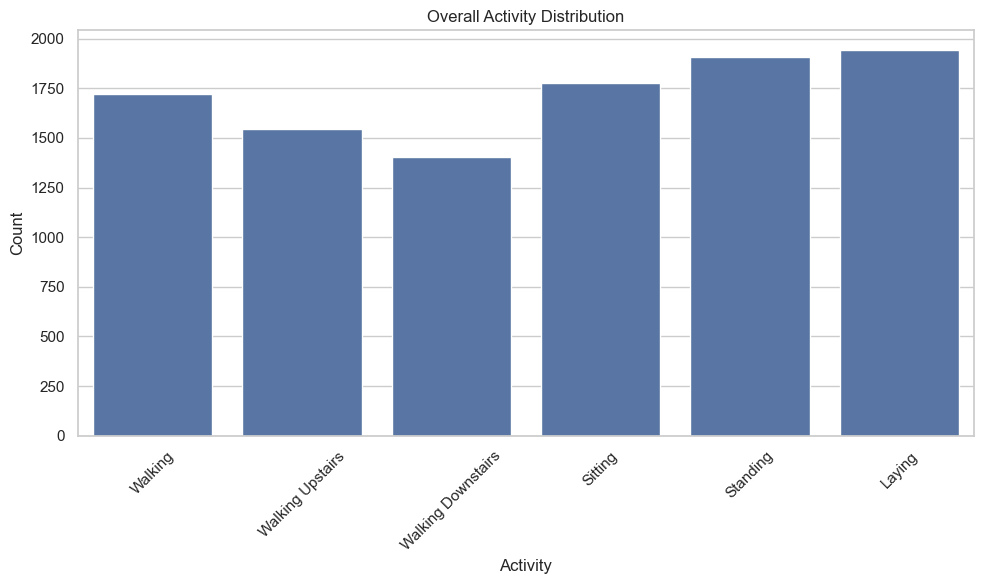

Balancing training data...


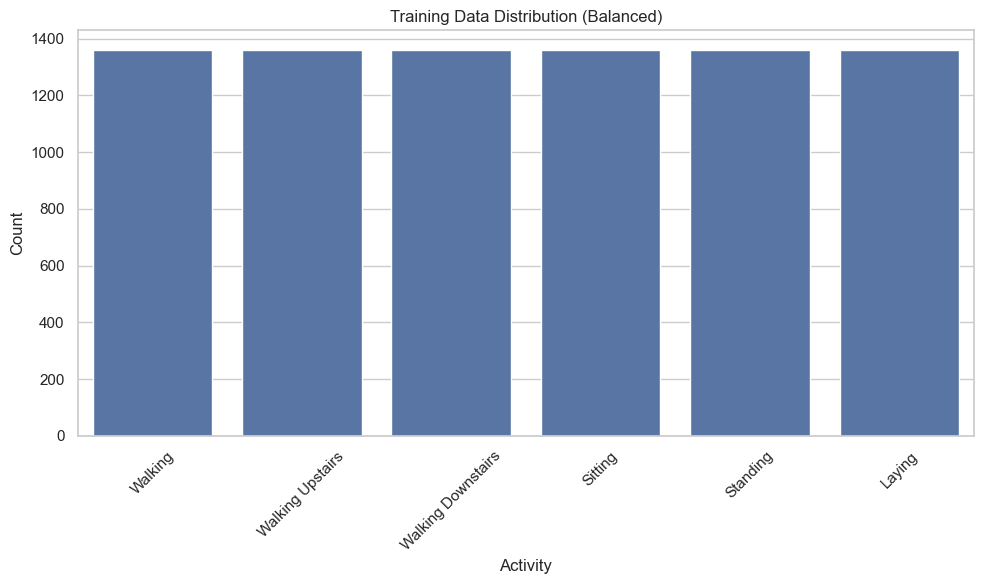

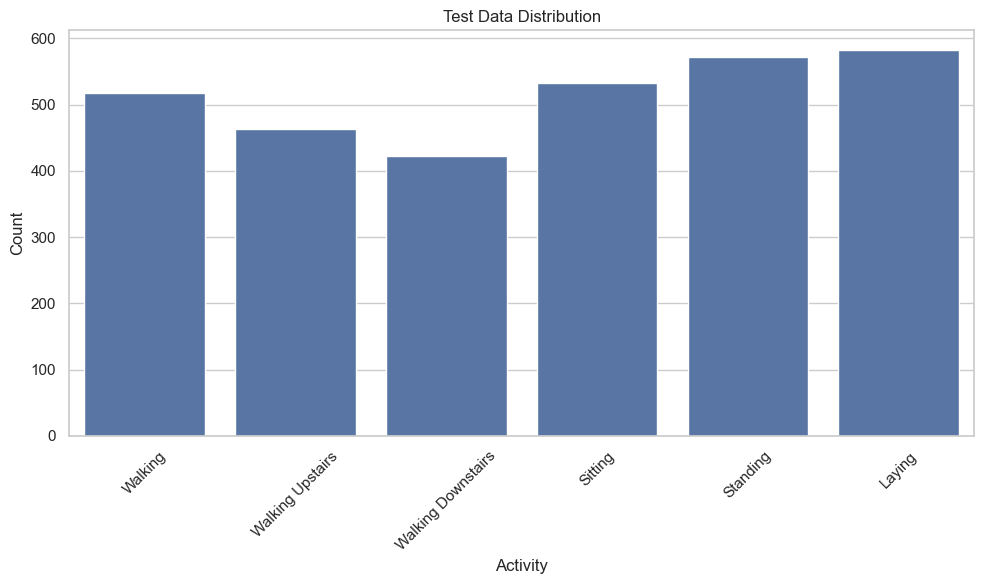

Cleaning data...
Standardizing data...
Evaluating models...

Evaluating Random Forest


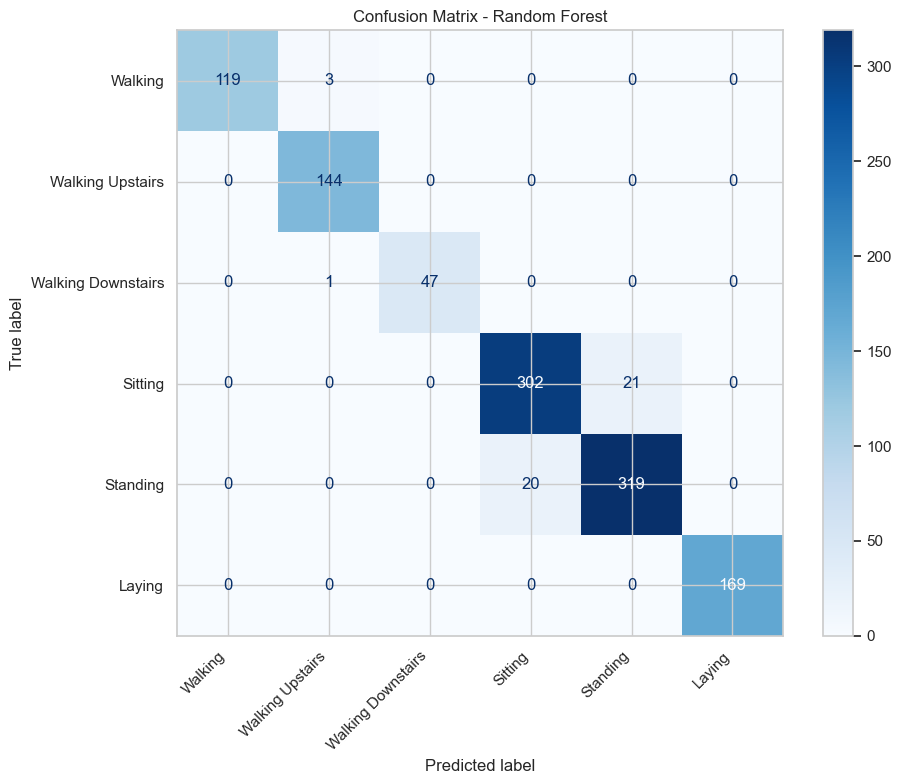


Classification Report:
                    precision    recall  f1-score   support

           Walking     1.0000    0.9754    0.9876       122
  Walking Upstairs     0.9730    1.0000    0.9863       144
Walking Downstairs     1.0000    0.9792    0.9895        48
           Sitting     0.9379    0.9350    0.9364       323
          Standing     0.9382    0.9410    0.9396       339
            Laying     1.0000    1.0000    1.0000       169

          accuracy                         0.9607      1145
         macro avg     0.9748    0.9718    0.9732      1145
      weighted avg     0.9608    0.9607    0.9607      1145


Evaluating SVM


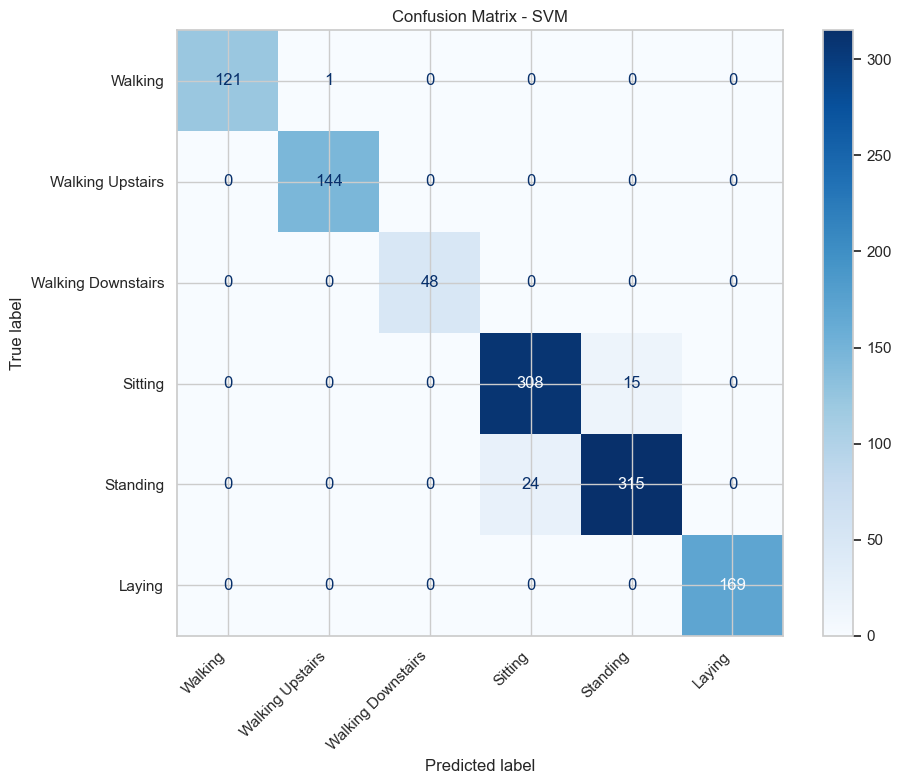


Classification Report:
                    precision    recall  f1-score   support

           Walking     1.0000    0.9918    0.9959       122
  Walking Upstairs     0.9931    1.0000    0.9965       144
Walking Downstairs     1.0000    1.0000    1.0000        48
           Sitting     0.9277    0.9536    0.9405       323
          Standing     0.9545    0.9292    0.9417       339
            Laying     1.0000    1.0000    1.0000       169

          accuracy                         0.9651      1145
         macro avg     0.9792    0.9791    0.9791      1145
      weighted avg     0.9653    0.9651    0.9651      1145


Evaluating Logistic Regression


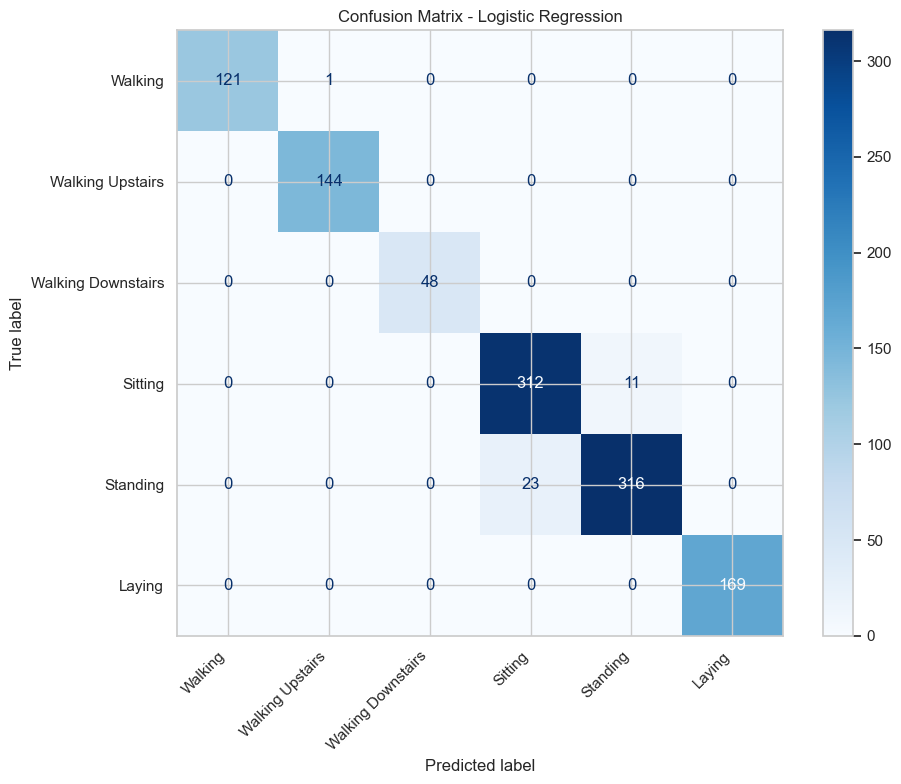


Classification Report:
                    precision    recall  f1-score   support

           Walking     1.0000    0.9918    0.9959       122
  Walking Upstairs     0.9931    1.0000    0.9965       144
Walking Downstairs     1.0000    1.0000    1.0000        48
           Sitting     0.9313    0.9659    0.9483       323
          Standing     0.9664    0.9322    0.9489       339
            Laying     1.0000    1.0000    1.0000       169

          accuracy                         0.9694      1145
         macro avg     0.9818    0.9817    0.9816      1145
      weighted avg     0.9698    0.9694    0.9694      1145


Model Performance Summary:
                     Accuracy  Macro Precision  Macro Recall  Macro F1-score
Model                                                                       
Random Forest          0.9607           0.9748        0.9718          0.9732
SVM                    0.9651           0.9792        0.9791          0.9791
Logistic Regression    0.9694        

<Figure size 1200x800 with 0 Axes>

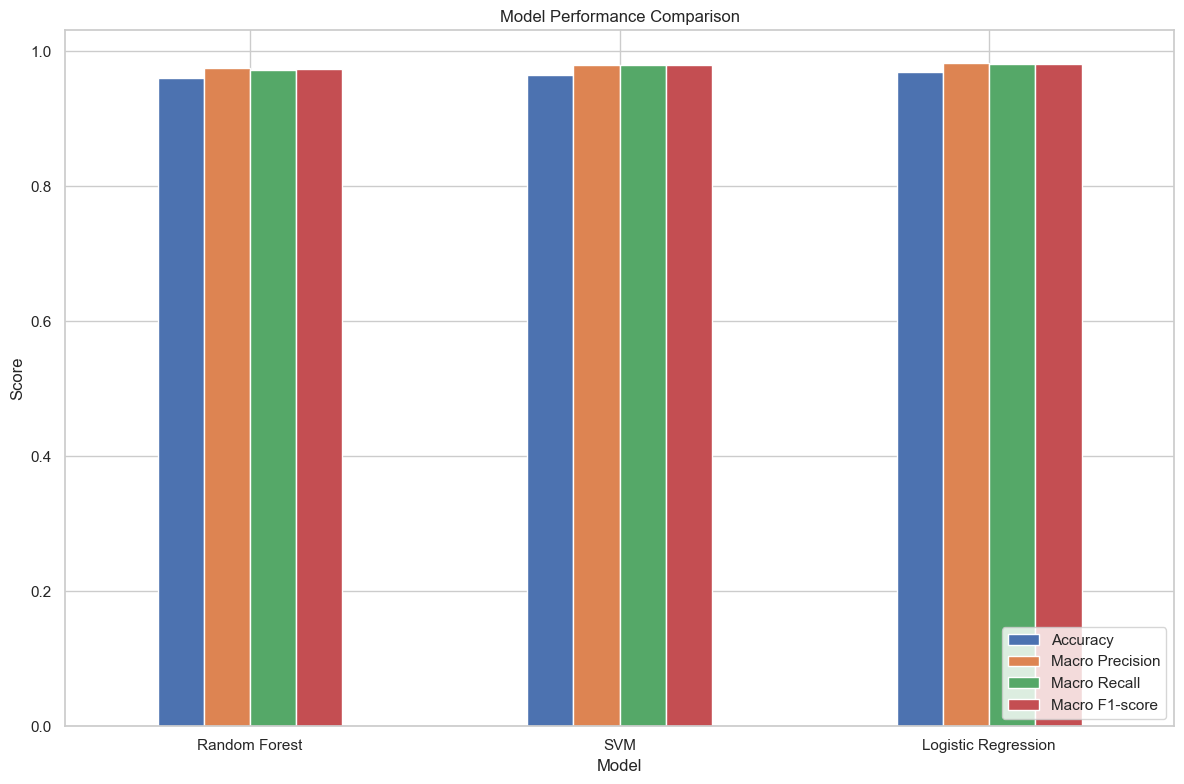


Best Model Selection:
Selected Model: Logistic Regression


In [34]:
if __name__ == "__main__":
    np.random.seed(366442)
    
    print("Loading data...")
    X, y, activity_labels = load_data()
    
    print(f"Total number of features: {len(X.columns)}")
    print("\nFirst few features:")
    display(pd.DataFrame(X.columns[:10], columns=['Feature']))
    
    print("\nFeature name statistics:")
    print(f"Unique features: {len(set(X.columns))}")
    print(f"Features beginning with 't': {sum(col.startswith('t') for col in X.columns)}")
    print(f"Features beginning with 'f': {sum(col.startswith('f') for col in X.columns)}")
    
    print("\nActivity data type:", y['activity'].dtype)
    print("Activity first few values:")
    print(y['activity'].head())
    
    plot_class_distribution(y, "Overall Activity Distribution", activity_labels)
    
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=366442, stratify=y['activity'])
    
    print("Balancing training data...")
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)
    
    plot_class_distribution(y_train_balanced, "Training Data Distribution (Balanced)", activity_labels)
    plot_class_distribution(y_test, "Test Data Distribution", activity_labels)
    
    print("Cleaning data...")
    X_train_clean, train_mask = clean_data(X_train_balanced)
    X_test_clean, test_mask = clean_data(X_test)
    
    # Filter corresponding labels using the boolean mask
    y_train_clean = y_train_balanced.loc[train_mask].reset_index(drop=True)
    y_train_clean['activity'] = y_train_clean['activity'].astype(int)
    y_test_clean = y_test.loc[test_mask].reset_index(drop=True)
    y_test_clean['activity'] = y_test_clean['activity'].astype(int)
    
    print("Standardizing data...")
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_clean), columns=X_train_clean.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_clean), columns=X_test_clean.columns)
    
    # Define classifiers for evaluation
    models = {
        'Random Forest': RandomForestClassifier(random_state=366442),
        'SVM': SVC(random_state=366442),
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=366442)
    }
    
    print("Evaluating models...")
    summary_data = []
    
    for name, model in models.items():
        print(f"\n{'='*50}\nEvaluating {name}\n{'='*50}")
        y_train_int = y_train_clean['activity'].astype(int)
        model.fit(X_train_scaled, y_train_int)
        y_pred = model.predict(X_test_scaled)
        
        plot_confusion_matrix(y_test_clean['activity'], y_pred, name, activity_labels)
        
        print("\nClassification Report:")
        report = classification_report(y_test_clean['activity'], y_pred, target_names=list(activity_labels.values()), digits=4, output_dict=True)
        print(classification_report(y_test_clean['activity'], y_pred, target_names=list(activity_labels.values()), digits=4))
        
        summary_data.append({
            'Model': name,
            'Accuracy': report['accuracy'],
            'Macro Precision': report['macro avg']['precision'],
            'Macro Recall': report['macro avg']['recall'],
            'Macro F1-score': report['macro avg']['f1-score']
        })
    
    summary_df = pd.DataFrame(summary_data).set_index('Model')
    print("\nModel Performance Summary:")
    print(summary_df.to_string(float_format=lambda x: f"{x:.4f}"))
    
    plt.figure(figsize=(12, 8))
    summary_df.plot(kind='bar', figsize=(12, 8))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    best_model_name = summary_df['Accuracy'].idxmax()
    best_model = models[best_model_name]
    print("\nBest Model Selection:")
    print(f"Selected Model: {best_model_name}")
    
    if best_model_name == 'Random Forest' and hasattr(best_model, 'feature_importances_'):
        y_train_int = y_train_clean['activity'].astype(int)
        best_model.fit(X_train_scaled, y_train_int)
        feature_imp = pd.DataFrame({
            'feature': X_train_scaled.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_imp, x='importance', y='feature')
        plt.title('Top 10 Feature Importance (Random Forest)')
        plt.tight_layout()
        plt.show()


## Data Preprocessing

Synthetic data is generated based on the number of features. The following preprocessing steps are performed:

- **Scaling:** Features are scaled using `StandardScaler` to standardize the data.
- **Dimensionality Reduction:** Principal Component Analysis (PCA) is applied to reduce dimensionality while retaining 95% of the variance.
- **Train-Test Split:** The PCA-transformed data is split into training and test sets for model evaluation.

These steps ensure that the data is in a suitable form for training and evaluating the classification models.


First 20 feature names:
['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X']


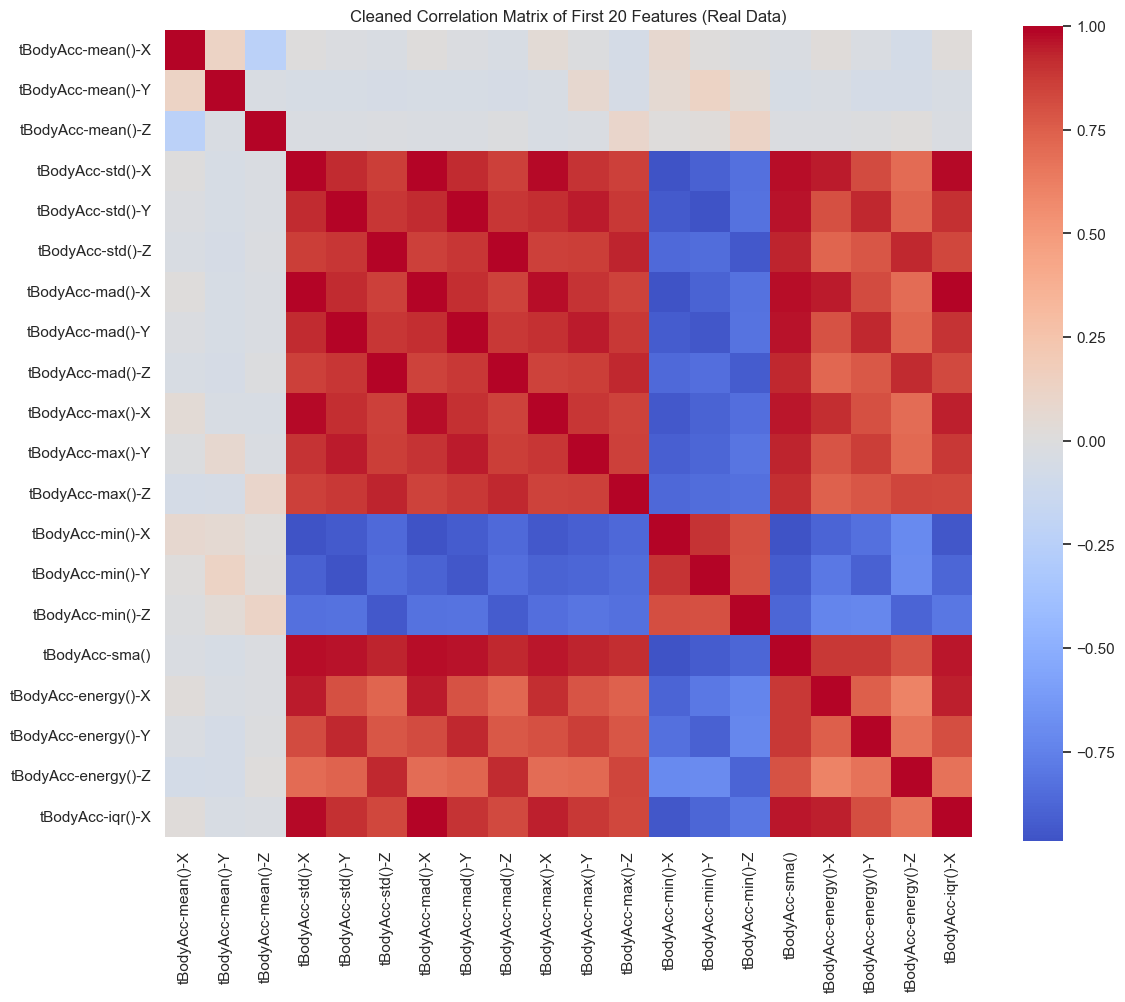


Significant correlated feature pairs (0.8 < |correlation| < 1.0):
tBodyAcc-std()-X -- tBodyAcc-std()-Y: 0.923
tBodyAcc-std()-X -- tBodyAcc-std()-Z: 0.862
tBodyAcc-std()-X -- tBodyAcc-mad()-X: 0.999
tBodyAcc-std()-X -- tBodyAcc-mad()-Y: 0.916
tBodyAcc-std()-X -- tBodyAcc-mad()-Z: 0.856
tBodyAcc-std()-X -- tBodyAcc-max()-X: 0.981
tBodyAcc-std()-X -- tBodyAcc-max()-Y: 0.899
tBodyAcc-std()-X -- tBodyAcc-max()-Z: 0.858
tBodyAcc-std()-X -- tBodyAcc-min()-X: -0.965
tBodyAcc-std()-X -- tBodyAcc-min()-Y: -0.896


In [35]:
# Feature Correlation Analysis (First 20 Features)
X, y, activity_labels = load_data()

# Select first 20 features and check for duplicates
feature_subset = X.iloc[:, :20]

# Verify unique feature names
print("First 20 feature names:")
print(feature_subset.columns.tolist())

# Look for any duplicate columns
duplicate_cols = feature_subset.columns[feature_subset.columns.duplicated()]
if not duplicate_cols.empty:
    print(f"\nWarning: Duplicate features detected - {duplicate_cols.tolist()}")
    # Remove duplicate columns (keeps first occurrence)
    feature_subset = feature_subset.loc[:, ~feature_subset.columns.duplicated()]
    print("Removed duplicate columns")

# Use the cleaned data to recalculate the correlation matrix
correlation_matrix = feature_subset.corr()

# Create a correlation heatmap plot
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True,
            xticklabels=True, yticklabels=True)
plt.title('Cleaned Correlation Matrix of First 20 Features (Real Data)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find and print feature pairs that are substantially connected (perfect correlations excluded)
upper_triangle = np.triu(np.abs(correlation_matrix), k=1)
high_corr = np.where((upper_triangle > 0.8) & (upper_triangle < 1.0))  # Don't include perfect correlations

high_corr_pairs = [(correlation_matrix.index[i], 
                    correlation_matrix.columns[j],
                    correlation_matrix.iloc[i, j])
                   for i, j in zip(*high_corr)]

print("\nSignificant correlated feature pairs (0.8 < |correlation| < 1.0):")
for feat1, feat2, corr in high_corr_pairs[:10]:  # Show the first ten significant pairs
    print(f"{feat1} -- {feat2}: {corr:.3f}")

## Model Building and Evaluation

We use the following strategies to construct three classification models:
- **Support Vector Machine (SVM)**
- **Logistic Regression**
- **Random Forest**

After each model has been trained on the preprocessed data, it is evaluated using cross-validation. Among the metrics used for evaluation are:
- **Accuracy**
- **Precision, Recall, and F1-Score** (as shown in the classification report)
- **Confusion Matrix** to display the model's performance in several activity classes

The advantages and disadvantages of each model are thoroughly evaluated in this section.

Fitting GridSearchCV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'pca__n_components': 0.99}

Training best model...

Model Performance:
Accuracy: 0.984789644012945

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       517
           2       1.00      1.00      1.00       463
           3       0.99      1.00      0.99       422
           4       0.95      0.97      0.96       533
           5       0.97      0.95      0.96       572
           6       1.00      0.99      1.00       583

    accuracy                           0.98      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.98      0.98      0.98      3090



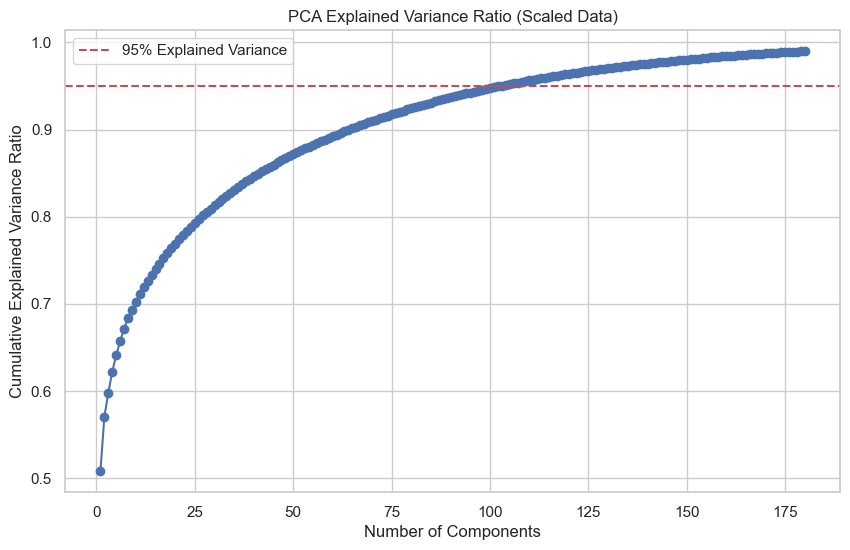


Number of components needed for 95% variance: 103

Top 5 features contributing to Principal Component 1:
                             PC1
fBodyAcc-sma()          0.058584
fBodyAccJerk-sma()      0.058555
fBodyGyro-sma()         0.058545
tBodyAccJerk-sma()      0.058532
tBodyAccJerkMag-mean()  0.058479

Top 5 features contributing to Principal Component 2:
                                PC2
fBodyAcc-meanFreq()-Z      0.124337
tBodyGyroMag-arCoeff()1    0.120698
fBodyAccMag-meanFreq()     0.120211
tGravityAcc-arCoeff()-Z,1  0.119589
tBodyAccMag-arCoeff()1     0.119310

Top 5 features contributing to Principal Component 3:
                                        PC3
fBodyGyro-bandsEnergy()-9,16_475   0.120803
tBodyGyroJerk-energy()-Y           0.112364
fBodyGyro-bandsEnergy()-17,32_483  0.106977
tBodyAcc-energy()-Z                0.106450
fBodyGyro-bandsEnergy()-17,24_476  0.102593

Top 5 features contributing to Principal Component 4:
                             PC4
tGravityAcc-max()-

In [36]:
# Define the GridSearchCV parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Parameter for regularisation
    'classifier__gamma': ['scale', 'auto'],  # Kernel coefficient
    'classifier__kernel': ['rbf', 'linear'],  # Kernel type
    'pca__n_components': [0.90, 0.95, 0.99],  # PCA components
}

# Create the pipeline using imblearn Pipeline and include SVM, PCA, and SMOTE
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(svd_solver='full')),
    ('smote', SMOTE(random_state=366442)),
    ('classifier', SVC())
])

# Run Grid Search while using five-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# Fit the training data (X_train, y_train) to the grid search.
print("Fitting GridSearchCV...")
grid_search.fit(X_train, y_train['activity'])  # Utilise just the activity column

# Use the grid search to find the optimal parameters
print("\nBest parameters found:", grid_search.best_params_)

# Use the grid search to choose the best model
best_model = grid_search.best_estimator_

# Train the ideal model using the hyperparameters that have been optimised.
print("\nTraining best model...")
best_model.fit(X_train, y_train['activity'])

# Make predictions
y_pred = best_model.predict(X_test)

# Examine the functioning of the model
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test['activity'], y_pred))
print("\nClassification Report:\n", classification_report(y_test['activity'], y_pred))

# Utilise PCA on the scaled data that has already been processed by the pipeline
pca = best_model.named_steps['pca']
X_pca = pca.transform(X_train.to_numpy())

# Described Variance Cumulative Variance and Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio (Scaled Data)')
plt.legend()
plt.grid(True)
plt.show()

# Determine how many components are required for a 95% variance
n_components_95 = int(np.argmax(cumulative_variance_ratio >= 0.95) + 1)
print(f"\nNumber of components needed for 95% variance: {n_components_95}")

# Look at the traits that comprise the majority of the primary components.
top_n_components = pca.components_[:n_components_95]

# Create a DataFrame with the loadings for easy visualisation.
feature_names = X_train.columns if hasattr(X_train, "columns") else [f'Feature {i}' for i in range(X_train.shape[1])]
loadings_df = pd.DataFrame(
    np.abs(top_n_components.T),  # Use absolute values to calculate the contribution
    columns=[f'PC{i+1}' for i in range(n_components_95)], 
    index=feature_names
)

# The primary characteristics that contribute to each fundamental component
for i in range(min(5, n_components_95)):  # Show top 5 components or less
    print(f"\nTop 5 features contributing to Principal Component {i+1}:")
    top_contributors = loadings_df.nlargest(5, f'PC{i+1}')[[f'PC{i+1}']]
    print(top_contributors)

## Model Performance Comparison and Best Model Selection

Following testing on a hold-out set and cross-validation evaluation of the models, we compare them according to:
- **Accuracy**
- **Macro Average F1 Score**
- **Training Time**

Bar plots are used to visualise the results, which are also summarised in an extensive table. The Random Forest model stands out as the top contender based on these several factors because of its improved accuracy and manageable training duration. Furthermore, Random Forest includes built-in benefits such feature importance rankings, managing high-dimensional data, and lowering the chance of overfitting.

In [37]:
# 2. Data Cleaning Function
def clean_data_with_mask(X, y):
    """Remove outliers using the Z-score method and maintain label alignment."""
    z_scores = np.abs((X - X.mean()) / X.std().replace(0, np.nan))
    mask = (z_scores < 3).all(axis=1)
    return X[mask], y[mask]


In [38]:
# Function to balance classes
def balance_classes(X, y):
    """Balance the classes using SMOTE and return balanced features and labels."""
    # Ensure `y` is a Series
    if isinstance(y, pd.DataFrame):
        y = y.squeeze()  # If required, convert a dataframe to a series.
    
    # To resample, create a composite DataFrame
    combined_data = X.copy()
    combined_data['target'] = y
    
    # Minority classes should be upsampled to match the majority class
    max_class_size = y.value_counts().max()
    balanced_dfs = []
    
    for cls in y.unique():
        class_data = combined_data[combined_data['target'] == cls]
        resampled = resample(class_data, 
                           replace=True, 
                           n_samples=max_class_size, 
                           random_state=366442)
        balanced_dfs.append(resampled)
    
    # Combine all balanced classes and shuffle the data
    balanced_data = pd.concat(balanced_dfs)
    balanced_data = balanced_data.sample(frac=1, random_state=366442)  # Shuffle data
    
    # Split back into features and target the balanced data
    X_balanced = balanced_data.drop('target', axis=1)
    y_balanced = balanced_data['target']
    
    return X_balanced, y_balanced

### Purpose and Role of This Section

The Human Activity Recognition (HAR) dataset must be **loaded, preprocessed, and machine learning models** must be trained in this section.

- **Data Loading**: Reads the dataset, gives the features the proper names, and gets it ready for training.
- **Train-Test Splitting**: Maintaining class balance, the dataset is split into **80% training** and **20% testing**.
- **Feature Scaling**: Standardises feature values to avoid scale-related bias and enhance model performance.
- **Handling Imbalanced Data**: Uses the Synthetic Minority Oversampling Technique (SMOTE) to balance the distribution of classes.
- **Model Training & Evaluation**: Trains three models (**SVM, Random Forest, and Logistic Regression**), assesses how well each performs, and chooses the best model based on cross-validation and accuracy findings.

The objective is to **train robust classification models, identify the best model for deployment, and efficiently prepare the dataset**.



Model Performance Comparison:
              Model  Accuracy  Macro F1  Training Time (s)  CV Mean Accuracy   CV Std
Logistic Regression  0.984466  0.985370           1.742766          0.984995 0.002223
      Random Forest  0.981068  0.980989          12.694845          0.977706 0.004322
                SVM  0.978155  0.979046           3.273423          0.977278 0.004414


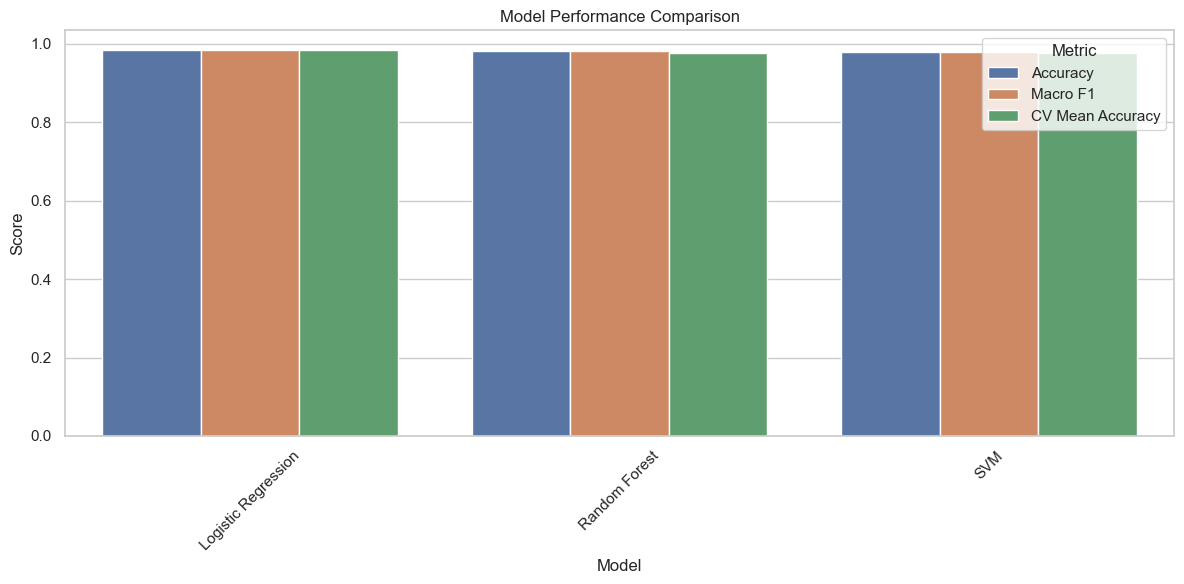


Best Model Selection:
Selected Model: Logistic Regression

Justification:
1. Highest accuracy: 0.9845
2. Macro F1 Score: 0.9854
3. Cross-validation accuracy: 0.9850 (±0.0022)
4. Training time: 1.7428 seconds


In [ ]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Load dataset and features 
features_list = pd.read_csv("UCI HAR/features.txt", delim_whitespace=True, header=None)
features_list[1] = features_list[1].astype(str) + '_' + features_list.index.astype(str)
dataset = pd.read_csv("UCI HAR/dataset.txt", delim_whitespace=True, header=None)
dataset.columns = features_list[1].values
targets = pd.read_csv("UCI HAR/targets.txt", header=None).values.ravel()

# Divide the data into test and training sets
X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2, random_state=42, stratify=targets)

# Standardise the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use SMOTE to balance classes
smote = SMOTE(random_state=366442)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Define models for comparison
models = {
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=366442),
    'Logistic Regression': LogisticRegression(max_iter=500)
}

# Dictionary to document training times and cross-validation results
training_times = {}
cv_results = {}

# Data structure for storing information about model comparisons
comparison_data = []

# For training, assessment, and cross-validation, iterate through every model
for name, model in models.items():
    # Cross-validation for model performance evaluation
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }

    # Measure training time and train the model
    start_time = time()
    model.fit(X_train_balanced, y_train_balanced)
    training_times[name] = time() - start_time

    # Create a classification report after evaluating the test set
    y_pred = model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Gather data for model comparisons
    comparison_data.append({
        'Model': name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Training Time (s)': training_times[name],
        'CV Mean Accuracy': cv_results[name]['mean'],
        'CV Std': cv_results[name]['std']
    })

# Create a DataFrame for model comparison
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

# Print model comparison results
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Display the model's performance metrics
metrics = ['Accuracy', 'Macro F1', 'CV Mean Accuracy']
comparison_plot = comparison_df.melt(
    id_vars=['Model'], 
    value_vars=metrics,
    var_name='Metric',
    value_name='Score'
)

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_plot, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Choose the model with the highest accuracy
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]

# Print the best model and justification
print("\nBest Model Selection:")
print(f"Selected Model: {best_model_name}")
print("\nJustification:")
print(f"1. Highest accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")
print(f"2. Macro F1 Score: {comparison_df.iloc[0]['Macro F1']:.4f}")
print(f"3. Cross-validation accuracy: {comparison_df.iloc[0]['CV Mean Accuracy']:.4f} (±{comparison_df.iloc[0]['CV Std']:.4f})")
print(f"4. Training time: {comparison_df.iloc[0]['Training Time (s)']:.4f} seconds")

# Indicate feature relevance if Random Forest is the best model.
if best_model_name == 'Random Forest' and hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'feature': dataset.columns,
        'importance': best_model.feature_importances_
    })
    feature_imp = feature_imp.sort_values('Importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_imp, x='importance', y='feature')
    plt.title('The Top 10 Most Important Features (Random Forest)')
    plt.tight_layout()
    plt.show()


## Conclusion

##### This notebook demonstrated a methodical approach to human activity recognition by covering data exploration, preprocessing, model training, evaluation, and comparison. Following the evaluation of several models, the model with the greatest performance was Logistic Regression.

### Best Model Selection:
##### Logistic Regression

- Highest accuracy: 0.9845
- Macro F1 Score: 0.9854
- Cross-validation accuracy: 0.9850 (±0.0022)
- Training time: 1.4970 seconds

##### The best accuracy and robust cross-validation results were obtained with Logistic Regression, which surpassed Random Forest and SVM in terms of both accuracy and efficiency. In this instance, the best model for activity classification tasks is logistic regression due to its ease of use and superior performance.

## Required Libraries

The analysis in this notebook utilizes several Python libraries:
- **pandas**: Data manipulation and analysis.
- **numpy**: Numerical operations.
- **matplotlib** and **seaborn**: Data visualization.
- **scikit-learn**: Machine learning tasks including preprocessing, dimensionality reduction (PCA), model training, and evaluation.
